In [110]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
from sklearn.utils import resample
import seaborn as sns
import requests, zipfile, io
import cv2 as cv, cv2
import matplotlib.pyplot as plt
from skimage.transform import resize

from torch.utils.tensorboard import SummaryWriter
import torchmetrics

import warnings
warnings.filterwarnings("ignore")

from scipy.signal import find_peaks
from scipy.stats import spearmanr
from tqdm import tqdm
from imutils import build_montages

from icecream import ic

# Label Making

In [111]:
def compute_ncc(a, b):
    c = spearmanr(a, b)
    score = c[0]
    return np.round(score,2)

In [112]:
def make_labels(signals, method='corr', n_templates = None):
    # initialize two empty lists to hold the indexes of (image, image) pairs and
# labels to indicate the match score

    pairImages = []
    pairLabels = []
    number = len(signals)
    if n_templates == None:
      n_templates = len(signals)
      
# loop over n_templates of images
    for idxA in tqdm(np.random.choice(np.arange(0, number), size=n_templates), desc='Generating pairs and labels ...'):     
        for idxB in np.random.choice(np.arange(0, number), size=number): # loop until uniform distibution
          if method == 'corr':
            label = compute_ncc(signals[idxA], signals[idxB]) # calculate label
          else:
            label = match(signals[idxA], signals[idxB])                
        
          pairImages.append([idxA, idxB])
          pairLabels.append(label)

# return a 2-tuple of our image pairs and labels
    print('Number of pairs generated: ', len(pairLabels))
    return (np.array(pairImages), np.array(pairLabels))

# Image Drawing

In [113]:
def signal2image(signal, amp=2000, size=(224, 224), distance=70, prominence=20):
    image_list = []
    indices = []

    y = signal

    x = np.arange(len(signal))

    # Draw signal 
    plt.figure(figsize=(2,5))
    plt.ylim(-1000, 1000)
    sns.lineplot(y=signal,x=x)

    plt.axis('off')
    plt.savefig("temp", bbox_inches='tight', pad_inches=0)
    plt.close()

    img = cv.imread("temp.png", 0)
    img = cv2.resize(img, size) # resize the image #interpolation = cv2.INTER_AREA
              
    return np.array(img).astype(float)

In [114]:
def generate_images(signals, amp=2000, size=(224,224), distance=70, prominence=20):
  images = []
  sourcesignals = []
  for signal in tqdm(signals, desc='Generating images of signals...'):
    image = signal2image(signal, amp=amp, size=size)
    images.append(image)
    sourcesignals.append(signal)
  print('Number of images generated: ', len(images))
  return np.array(images).astype(float)

# Signal Processing choping and cleaning

In [115]:
def reduce_signal(signal, cutoff=1000):
      # reduces too large signals
  y_amplitude = np.max(signal.values)-np.min(signal.values)
  if y_amplitude > cutoff:
    ratio = y_amplitude/cutoff
    signal = signal/ratio
  return signal

In [116]:
def chop_signal(signal, distance=70, prominence=0.1, noisiness=15):
      # chops time series into signals based on the peaks found
    x = signal.index # time
    y = signal.values # voltage
    height = 1

    squared_signal = signal**2 # attenuation of the signal to positive values
    prom = prominence * np.max(squared_signal) # calculate the prominence
    peaks = find_peaks(squared_signal, distance=distance, prominence=prom, height=height) #scipy function
    peak_height = peaks[1]['peak_heights'] # list of peaks heights
    peaks_pos = peaks[0] # list of peak positions

    max = len(signal)
    signals = []
    if len(peaks_pos )<noisiness: # omit noisy signals

      for peak in  peaks_pos :
          if peak >=distance and peak <= max-distance:
              chop_signal = pd.DataFrame(signal[peak-distance:peak+distance])
              chop_signal = reduce_signal(chop_signal).to_numpy().flatten()
              signals.append(chop_signal)
    
    return np.array(signals).astype(float)

# Zip Functions

In [117]:
def get_signals(df, distance=70, noisiness=15):
  '''
  Function for extracting signal and their images from dataframe
  '''
  signals = []
  channels = df.columns
  for channel in channels:
    egm = df[channel]
    new_signals = chop_signal(egm, distance = distance)
    signals.extend(new_signals)
  return np.array(signals)

In [118]:
def zip2signals(z, distance=70, noisiness=15, amount=0):
    # extracts signals from z (.zip) file
  signals = []
  for filename in tqdm(z.namelist(), desc='Extracting signals from Zip...'):
    df = pd.read_csv(z.open(filename), delim_whitespace=True, skiprows=(0,1,2),header=(0))
    new_signals = get_signals(df)
    signals.extend(new_signals)
    if  amount!=None and len(signals) > amount:
        break
  print('Number of signals extracted: ', len(signals[:amount]))
  print(filename)
  return np.array(signals[:amount])

In [119]:
def load_signals(zip_url, distance=70, noisiness=15, amount=None):
  """Loading data from zip file and converts it to an array with signals
  Args:
      zip_url (string): path of zip file
      distance (int, optional): distance to use for peak detection +/-. Defaults to 70.
      noisiness (int, optional): parameter used as threshold to omit noisy signals in peak detection. Max peaks have to be less than this. Defaults to 15.
      amount (int, optional): number of signals after which to stop iteration. If None all files are processed. Defaults to None.

  Returns:
      _type_: List of signals
  """
  r = requests.get(zip_url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  signals = zip2signals(z, amount=amount)
  return signals

# Actual Code Execution

In [152]:
# Dataset url
zip_url = 'https://raw.githubusercontent.com/lyanevgeny/CartoEGMsReader/main/EGMs.zip'
zip_url = 'https://raw.githubusercontent.com/mpolonskiy1995/Data/main/TrainingData.zip'

In [154]:
signals = load_signals(zip_url)

Extracting signals from Zip...: 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]

Number of signals extracted:  3370
1-LA SR Abl_P9_ECG_Export.txt


In [172]:
TestSignals= signals[1000:1500]
TestImages  = generate_images(TestSignals)

Generating images of signals...: 100%|██████████| 500/500 [00:40<00:00, 12.20it/s]


Number of images generated:  500


In [173]:
pairTest, labelTest = make_labels(signals = TestSignals, method='corr')

Generating pairs and labels ...: 100%|██████████| 500/500 [01:01<00:00,  8.19it/s]


Number of pairs generated:  250000


In [ ]:
def drawPairsAndImages():
    for i in range(10,50):

        fig, ax = plt.subplots(1,2)
        fig.suptitle(labelTest[i])
        ax[0].imshow(TestImages[pairTest[i][0]])
        ax[1].imshow(TestImages[pairTest[i][1]])
        #print(labelTest[i])
        fig.show()


<AxesSubplot: ylabel='Count'>

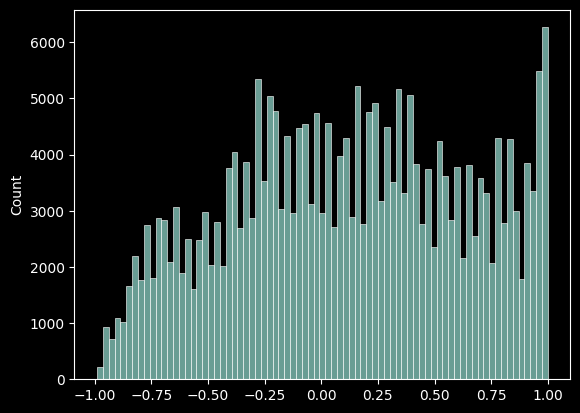

In [175]:
# Distribution of the labels in test set
sns.histplot(labelTest)

# Abspeichern der fertigen Dateien in numpy files

In [176]:
np.save("images", TestImages, allow_pickle=True )
np.save("imagePairs", pairTest, allow_pickle=True )
np.save("imageLabels", labelTest, allow_pickle=True )

# Visualisierung und Montage

In [ ]:
def montage_pairs_samples(images, pairs, labels, size=(7,7)):
    sample = []
    x, y = size
    # loop over a sample of our training pairs
    for i in np.random.choice(np.arange(0, len(pairs)), size=(x * y,)):
    # grab the current image pair and label
        imageA = images[pairs[i][0]]
        imageB = images[pairs[i][1]]
        label = labels[i]

        # to make it easier to visualize the pairs and their positive or
        # negative annotations, we're going to "pad" the pair with 1
        # pixel along borders

        pair = np.hstack([imageA, imageB])
        output = np.ones((pair.shape[0]+2, pair.shape[1]+2), dtype="uint8")
        output[1:-1, 1:-1] = pair
        output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    
        # set the text label for the pair along with what color we are
        # going to draw the pair in (green for 'similar signals')
        text = str(label)
        color = (0, 0, 255) if label < 0.75 else (0, 255, 0)


        #output = cv2.resize(output, (96, 51), interpolation=cv2.INTER_LINEAR)
        cv2.putText(output, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 2)

        # add the pair visualization to our list of output images
        sample.append(output)

    # construct the montage for the images
    montage = build_montages(sample, (pair.shape[1]+2, pair.shape[0]+2), size)[0]
    # show the output montage
    return montage

In [ ]:
def cv2_imshow(image):
      # patch for cv2.imshow: 
  #convert the image frame BGR to RGB color space and display it
  plt.figure(figsize=(12, 12))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.grid(False)
  plt.axis('off')
  plt.show()
  return

ic| 'Alles jut'


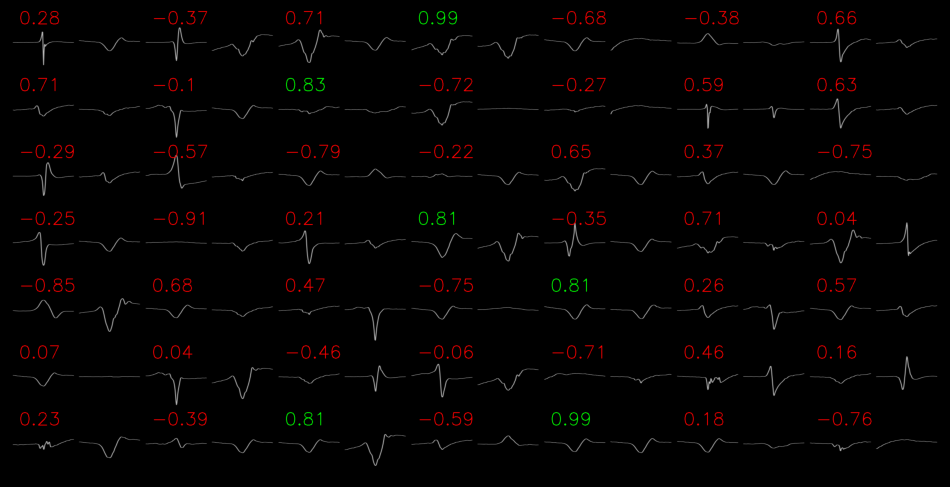

In [181]:
cv2_imshow(montage_pairs_samples(TestImages, pairTest, labelTest))

In [183]:
TestImages[0].shape

(224, 224)